# Autoencoders 

Autoencoders are artificial neural networks capable of learning efficient representations of the input data, called __codings__, without any supervision. These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction. More importantly, autoencoders act as powerful feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, they are capable of randomly __generating new data__ that looks very similar to the training data; this is called a generative model. For example, you could train an autoencoder on pictures of faces, and it would then be able to generate new faces.

You can limit the size of the internal representation, or you can add noise to the inputs and train the network to recover the original inputs. __These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs__, which forces it to learn efficient ways of representing the data. In short, __the codings are byproducts of the autoencoder’s attempt to learn the identity function under some constraints__.

The relationship between memory, perception, and pattern matching was famously studied by (Chase-Simon72). They observed that __expert chess players were able to memorize the positions of all the pieces in a game by looking at the board for just 5 seconds, a task that most people would find impossible__. However, this was only the case when the pieces were placed in __realistic positions__ (from actual games), __not when the pieces were placed randomly__. __Chess experts don’t have a much better memory than normal people__, __they just see chess patterns more easily thanks to their experience__ with the game. Noticing patterns helps them store information efficiently. 

An autoencoder typically has the same architecture as a __Multi-Layer Perceptron__ (MLP), except that the __number of neurons in the output layer must be equal to the number of inputs__.

In typical __encoder__ / __decoder__ architectures the outputs are often called the __reconstructions__ since the autoencoder tries to reconstruct the inputs, and the cost function contains a __reconstruction loss__ that penalizes the model when the reconstructions are different from the inputs.

<img src="images/encoders1.jpg" />

## PCA with a linear Autoencoder

If the autoencoder uses only __linear activations__ and the __cost function__ is the __Mean Squared Error (MSE)__, then it can be shown that it ends up performing __Principal Component Analysis__. 

In [8]:
# Tensorflow
import tensorflow as tf 
from tensorflow.contrib.layers import fully_connected

# Common imports
import numpy as np
import numpy.random as rnd
import os
import sys

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [14]:
rnd.seed(4)
m = 100
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
X_train = np.empty((m, 3))
X_train[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
X_train[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
X_train[:, 2] = X_train[:, 0] * w1 + X_train[:, 1] * w2 + noise * rnd.randn(m)

# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

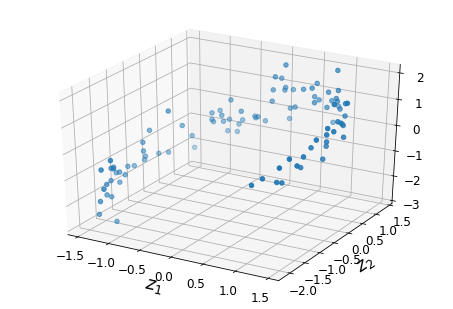

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter3D(X_train[:, 0], X_train[:, 1], X_train[:, 2])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
pyplot.show()

__Autoencoder__

In [10]:
##
tf.reset_default_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = fully_connected(X, n_hidden, activation_fn=None)
outputs = fully_connected(hidden, n_outputs, activation_fn=None)

mse = tf.reduce_mean(tf.square(outputs - X))
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

##
n_iterations = 10000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_train})

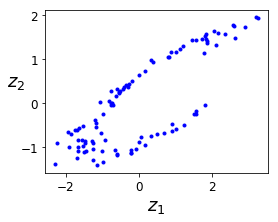

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked Autoencoders on MNIST

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

In [23]:
tf.reset_default_graph()

from tensorflow.contrib.layers import fully_connected

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

initializer = tf.contrib.layers.variance_scaling_initializer() # initialization

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
with tf.contrib.framework.arg_scope([fully_connected],
                                    activation_fn=tf.nn.elu,
                                    weights_initializer=initializer,
                                    weights_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)):
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2)
    hidden3 = fully_connected(hidden2, n_hidden3)
    outputs = fully_connected(hidden3, n_outputs, activation_fn=None)

mse = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([mse] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's train it! Note that we don't feed target values (y_batch is not used). This is unsupervised training.

In [24]:
n_epochs = 4
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        mse_train = mse.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

0 Train MSE: 0.0219669
1 Train MSE: 0.0125765
2 Train MSE: 0.0103965
3 Train MSE: 0.00993011



This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [28]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


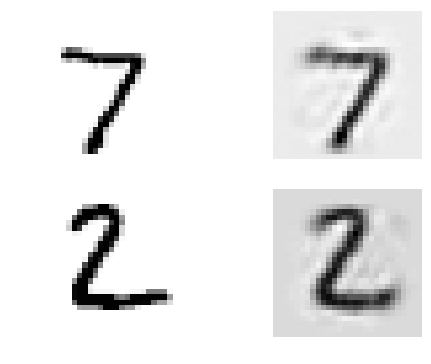

In [31]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt",n_test_digits = 2)

## Tying Weights

When an autoencoder is neatly symmetrical, like the one we just built, a common technique is to __tie the weights of the decoder layers to the weights of the encoder layers__. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. 

In [52]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose( weights2, name ="weights3") # tied weights 
weights4 = tf.transpose( weights1, name ="weights4") # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean( tf.square( outputs - X)) 
reg_loss = regularizer(weights1) + regularizer(weights2) 
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate) 
training_op = optimizer.minimize(loss) 
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [53]:
n_epochs = 4
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        mse_train = reconstruction_loss.eval(feed_dict={X: X_batch},session=sess)
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_tied.ckpt")

0 Train MSE: 0.0114661
1 Train MSE: 0.00763779
2 Train MSE: 0.00693481
3 Train MSE: 0.00729831


INFO:tensorflow:Restoring parameters from ./my_model_tied.ckpt


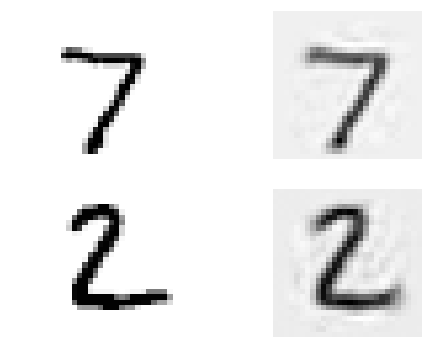

In [54]:
show_reconstructed_digits(X, outputs, "./my_model_tied.ckpt")

Highlights: 

1. __weight3__ and __weights4__ are not variables, they are respectively the transpose of weights2 and weights1 (they are “tied” to them). 
2. Since they are not variables, it’s no use regularizing them: we only regularize weights1 and weights2.
3. Biases are never tied, and never regularized.

## Training one Autoencoder at a time in multiple graphs

Rather than training the whole stacked autoencoder in one go like we just did, it is often much faster to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder. This is especially useful for very deep autoencoders.

There are many ways to train one Autoencoder at a time. The first approach it to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.Let's create a function that will train one autoencoder and return the transformed training set (ie. the output of the hidden layer) and the model parameters.

In [55]:
def train_autoencoder(X_train, n_neurons, n_epochs, batch_size, learning_rate = 0.01, l2_reg = 0.0005, activation_fn=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        with tf.contrib.framework.arg_scope(
                [fully_connected],
                activation_fn=activation_fn,
                weights_initializer=tf.contrib.layers.variance_scaling_initializer(),
                weights_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)):
            hidden = fully_connected(X, n_neurons, scope="hidden")
            outputs = fully_connected(hidden, n_inputs, activation_fn=None, scope="outputs")

        mse = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([mse] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            mse_train = mse.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", mse_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/weights:0"], params["hidden/biases:0"], params["outputs/weights:0"], params["outputs/biases:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [56]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.0177944
1 Train MSE: 0.0188232
2 Train MSE: 0.0195855
3 Train MSE: 0.0191368
0 Train MSE: 0.00453382
19% Train MSE: 0.00451651
2 Train MSE: 0.00443749
3 Train MSE: 0.004681


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [57]:
tf.reset_default_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

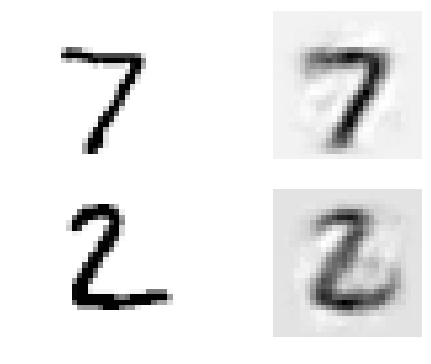

In [58]:
show_reconstructed_digits(X, outputs)

### Training one Autoencoder at a time in a single graph 

Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).

In [60]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4


with tf.name_scope("phase1"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_mse = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_mse + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    phase2_mse = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_mse + phase2_reg_loss
    phase2_training_op = optimizer.minimize(phase2_loss, 
                                            var_list=[weights2, biases2, weights3, biases3]) # freeze hidden1
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [61]:
training_ops = [phase1_training_op, phase2_training_op]
mses = [phase1_mse, phase2_mse]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            mse_train = mses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", mse_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    mse_test = mses[phase].eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", mse_test)

Training phase #1
0 Train MSE: 0.00773876
1 Train MSE: 0.00756009
2 Train MSE: 0.00787726
3 Train MSE: 0.00781984
Training phase #2
0 Train MSE: 0.00217559
1 Train MSE: 0.00226913
29% Train MSE: 0.00246423
3 Train MSE: 0.00310218
Test MSE: 0.00313138


INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


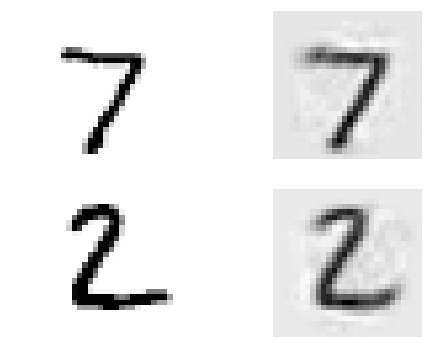

In [62]:
show_reconstructed_digits(X, outputs, "./my_model_one_at_a_time.ckpt")

## Visualizing Features

A technique for visualizing features is for each neuron in the first hidden layer, you can create an image where a pixel’s intensity corresponds to the weight of the connection to the given neuron.

In [63]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


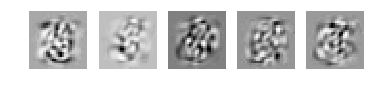

In [69]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

plt.show()

### Cache the frozen layer outputs

In [70]:
training_ops = [phase1_training_op, phase2_training_op, training_op]
mses = [phase1_mse, phase2_mse, mse]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            mnist_hidden1 = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(len(mnist_hidden1))
                    hidden1_batch = mnist_hidden1[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            mse_train = mses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", mse_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    mse_test = mses[phase].eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", mse_test)

Training phase #1
0 Train MSE: 0.0077867
1 Train MSE: 0.00743229
2 Train MSE: 0.00730401
3 Train MSE: 0.00772831
Training phase #2
0 Train MSE: 0.00226764
1 Train MSE: 0.00237887
2 Train MSE: 0.00263496
3 Train MSE: 0.00265333
Test MSE: 0.00283383


INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt


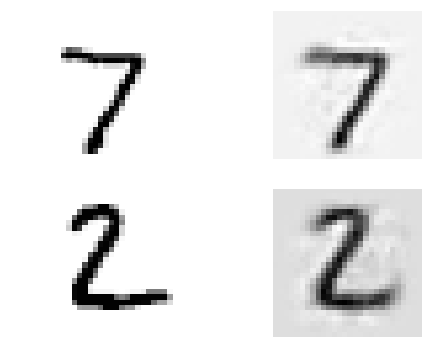

In [71]:
show_reconstructed_digits(X, outputs, "./my_model_cache_frozen.ckpt")

## Unsupervised Pretraining Using Stacked Autoencoders

If you have a large dataset but most of it is unlabeled, __you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task, and train it using the labeled data__. The stacked autoencoder itself is typically trained one autoencoder at a time, as discussed earlier. When training the classifier, if you really don’t have much labeled training data, you may want to freeze the pretrained layers (at least the lower ones).



In [72]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training (without pretraining):

In [74]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.933333 Test accuracy: 0.9228
1 Train accuracy: 0.973333 Test accuracy: 0.936
29% Train accuracy: 0.98 Test accuracy: 0.9424
3 Train accuracy: 0.953333 Test accuracy: 0.942


Now reusing the first two layers of the autoencoder we pretrained:

In [76]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.96	Test accuracy: 0.9314
1 Train accuracy: 0.96	Test accuracy: 0.9337
2 Train accuracy: 0.953333	Test accuracy: 0.941
3 Train accuracy: 0.986667	Test accuracy: 0.9472


One of the triggers of the current Deep Learning tsunami is the discovery in (Hinton et al., 2006) that __deep neural networks can be pretrained in an unsupervised fashion__. They used __restricted Boltzmann machines__ for that, but in (Bengio et al., 2006) showed that __autoencoders worked just as well__. There is nothing special about the TensorFlow implementation: just train an autoencoder using all the training data, then reuse its encoder layers to create a new neural network. Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer, making it undercomplete. 

## Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to __add noise to its inputs, training it to recover the original, noise-free inputs__. This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to __find patterns in the data__. The idea of using autoencoders to remove noise has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In a 2008 paper, 3 Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. The idea of using autoencoders to remove noise has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In (Pascal Vincent et al., 2008) showed that autoencoders could also be used for feature extraction. In (Vincent et al.,2010) it is introduced stacked denoising autoencoders.

### Denoising Autoencoders with Gaussian noise 

In [98]:
import math 

tf.reset_default_graph()

from tensorflow.contrib.layers import dropout

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.00001
keep_prob = 0.7

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
is_training = tf.placeholder_with_default(False, shape=(), name='is_training')
    
X_noisy = tf.cond(is_training, 
                  lambda: X + tf.random_normal(shape=tf.shape(X),mean=0,stddev=1/math.sqrt(n_hidden1)), ## Gaussian noise 
                  lambda: X)


weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X_noisy, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

optimizer = tf.train.AdamOptimizer(learning_rate)
mse = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = mse + reg_loss
training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [99]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, is_training: True})
        mse_train = mse.eval(feed_dict={X: X_batch, is_training: False})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_stacked_denoising.ckpt")

0 Train MSE: 0.0160436
1 Train MSE: 0.00962477
2 Train MSE: 0.00695359
3 Train MSE: 0.0058369
4 Train MSE: 0.00491672
5 Train MSE: 0.00483042
6 Train MSE: 0.00699327
7 Train MSE: 0.0672627
8 Train MSE: 0.0691902
9 Train MSE: 0.0691012


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising.ckpt


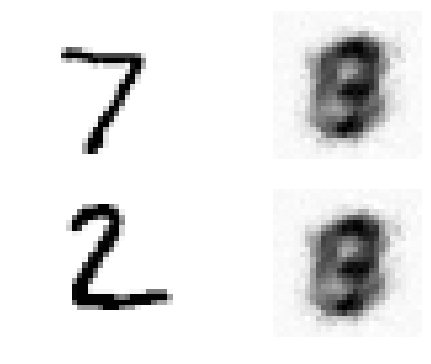

In [100]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising.ckpt")

__Note__
Since the shape of X is only partially defined during the construction phase, we cannot know in advance the shape of the noise that we must add to X. We cannot call X.get_shape() because this would just return the partially defined shape of X ([None, n_inputs]), and random_normal() expects a fully defined shape so it would raise an exception. Instead, we call tf.shape(X), which creates an operation that will return the shape of X at runtime, which will be fully defined at that point.

### Denoising Autoencoders with Dropout

In [80]:
tf.reset_default_graph()

from tensorflow.contrib.layers import dropout

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.00001
keep_prob = 0.7

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
is_training = tf.placeholder_with_default(False, shape=(), name='is_training')

X_drop = dropout(X, keep_prob, is_training=is_training)

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X_drop, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

optimizer = tf.train.AdamOptimizer(learning_rate)
mse = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = mse + reg_loss
training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [78]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, is_training: True})
        mse_train = mse.eval(feed_dict={X: X_batch, is_training: False})
        print("\r{}".format(epoch), "Train MSE:", mse_train)
        saver.save(sess, "./my_model_stacked_denoising.ckpt")

0 Train MSE: 0.0245671
1 Train MSE: 0.0156954
2 Train MSE: 0.0131523
3 Train MSE: 0.0117988
4 Train MSE: 0.0100413
5 Train MSE: 0.00974315
6 Train MSE: 0.00918222
7 Train MSE: 0.00880637
8 Train MSE: 0.00869177
9 Train MSE: 0.00908567


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising.ckpt


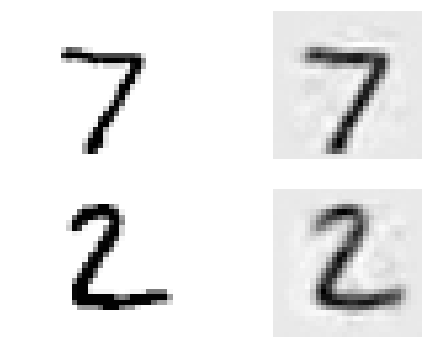

In [79]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising.ckpt")

## Sparse Autoencoders

Another kind of constraint that often leads to good feature extraction is sparsity: __by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer__. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to). In order to favor sparse models, we must first measure the actual sparsity of the coding layer at each training iteration. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. The batch size must not be too small, or else the mean will not be accurate. Once we have the mean activation per neuron, we want to penalize the neurons that are too active by adding a sparsity loss to the cost function. __For example, if we measure that a neuron has an average activation of 0.3, but the target sparsity is 0.1, it must be penalized to activate less__. One approach could be simply adding the squared error (0.3 – 0.1) 2 to the cost function, but in practice a better approach is to use the __Kullback– Leibler divergence__ which has much stronger gradients than the Mean Squared Error.

/Users/gino/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[0, 1, 0, 0.95]

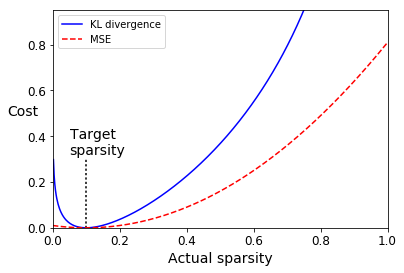

In [101]:
p = 0.1
q = np.linspace(0, 1, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [102]:
def kl_divergence(p, q):
    """Kullback Leibler divergence"""
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [103]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

#activation = tf.nn.softplus # soft variant of ReLU
activation = tf.nn.sigmoid
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_outputs), name="biases2")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
outputs = tf.matmul(hidden1, weights2) + biases2

optimizer = tf.train.AdamOptimizer(learning_rate)
mse = tf.reduce_mean(tf.square(outputs - X))

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
loss = mse + sparsity_weight * sparsity_loss
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [104]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        mse_val, sparsity_loss_val, loss_val = sess.run([mse, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", mse_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.097747 	Sparsity loss: 0.292068 	Total loss: 0.156161
1 Train MSE: 0.0563438 	Sparsity loss: 0.0308641 	Total loss: 0.0625166
2 Train MSE: 0.0480086 	Sparsity loss: 0.117752 	Total loss: 0.0715589
3 Train MSE: 0.0436715 	Sparsity loss: 0.0763076 	Total loss: 0.0589331
4 Train MSE: 0.0397885 	Sparsity loss: 0.0734568 	Total loss: 0.0544799
5 Train MSE: 0.03715 	Sparsity loss: 0.0360815 	Total loss: 0.0443663
6 Train MSE: 0.0324828 	Sparsity loss: 0.104327 	Total loss: 0.0533482
7 Train MSE: 0.0284582 	Sparsity loss: 0.0981715 	Total loss: 0.0480925
8 Train MSE: 0.0269465 	Sparsity loss: 0.0201862 	Total loss: 0.0309838
9 Train MSE: 0.0250389 	Sparsity loss: 0.0659021 	Total loss: 0.0382193
10 Train MSE: 0.0246506 	Sparsity loss: 0.160197 	Total loss: 0.05669
11 Train MSE: 0.0218129 	Sparsity loss: 0.0439904 	Total loss: 0.030611
12 Train MSE: 0.0219018 	Sparsity loss: 0.286851 	Total loss: 0.0792721
13 Train MSE: 0.0202175 	Sparsity loss: 0.035096 	Total loss: 0.0272368
1

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


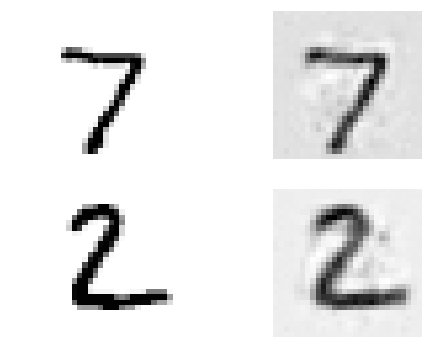

In [105]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

## Variational Autoencoders 

Another important category of autoencoders was introduced in (Kingma-Welling,2014) and has quickly become one of the most popular types of autoencoders: variational autoencoders. They are quite different from all the autoencoders we have discussed so far. They are __probabilistic autoencoders__, meaning that their outputs are partly determined by chance, even after training (__as opposed to denoising autoencoders, which use randomness only during training__). Most importantly, they are __generative autoencoders__, meaning that __they can generate new instances that look like they were sampled from the training set__. Both these properties make them rather similar to Restricted Boltzmann Machines (RBMs) but they are easier to train and the sampling process is much faster. 

Let’s take a look at how they work. You can recognize, of course, the basic structure of all autoencoders, with an encoder followed by a decoder but there is a __twist__: __instead of directly producing a coding for a given input, the encoder produces a mean coding μ and a standard deviation σ__. The __actual coding is then sampled randomly from a Gaussian distribution with mean μ and standard deviation σ__. After that the decoder just decodes the sampled coding normally. 

In [106]:
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

activation = tf.nn.elu
initializer = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG", uniform=True)

X = tf.placeholder(tf.float32, [None, n_inputs])

weights1 = tf.Variable(initializer([n_inputs, n_hidden1]))
weights2 = tf.Variable(initializer([n_hidden1, n_hidden2]))
weights3_mean = tf.Variable(initializer([n_hidden2, n_hidden3]))
weights3_log_sigma = tf.Variable(initializer([n_hidden2, n_hidden3]))
weights4 = tf.Variable(initializer([n_hidden3, n_hidden4]))
weights5 = tf.Variable(initializer([n_hidden4, n_hidden5]))
weights6 = tf.Variable(initializer([n_hidden5, n_inputs]))

biases1 = tf.Variable(tf.zeros([n_hidden1], dtype=tf.float32))
biases2 = tf.Variable(tf.zeros([n_hidden2], dtype=tf.float32))
biases3_mean = tf.Variable(tf.zeros([n_hidden3], dtype=tf.float32))
biases3_log_sigma = tf.Variable(tf.zeros([n_hidden3], dtype=tf.float32))
biases4 = tf.Variable(tf.zeros([n_hidden4], dtype=tf.float32))
biases5 = tf.Variable(tf.zeros([n_hidden5], dtype=tf.float32))
biases6 = tf.Variable(tf.zeros([n_inputs], dtype=tf.float32))

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)

hidden3_mean = tf.matmul(hidden2, weights3_mean) + biases3_mean
hidden3_log_sigma = tf.matmul(hidden2, weights3_log_sigma) + biases3_log_sigma
noise = tf.random_normal(tf.shape(hidden3_log_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.sqrt(tf.exp(hidden3_log_sigma)) * noise

hidden4 = activation(tf.matmul(hidden3, weights4) + biases4)
hidden5 = activation(tf.matmul(hidden4, weights5) + biases5)
logits = tf.matmul(hidden5, weights6) + biases6
outputs = tf.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_log_sigma) + tf.square(hidden3_mean) - 1 - hidden3_log_sigma)
cost = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [107]:
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

with tf.contrib.framework.arg_scope([fully_connected],
                                    activation_fn=tf.nn.elu,
                                    weights_initializer=initializer):
    X = tf.placeholder(tf.float32, [None, n_inputs])
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2)
    hidden3_mean = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_gamma = fully_connected(hidden2, n_hidden3, activation_fn=None)
    noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
    hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
    hidden4 = fully_connected(hidden3, n_hidden4)
    hidden5 = fully_connected(hidden4, n_hidden5)
    logits = fully_connected(hidden5, n_outputs, activation_fn=None)
    outputs = tf.sigmoid(logits)

reconstruction_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits))
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
cost = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [108]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        cost_val, reconstruction_loss_val, latent_loss_val = sess.run([cost, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train cost:", cost_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train cost: 18368.9 	Reconstruction loss: 14606.0 	Latent loss: 3762.96
19% Train cost: 18136.7 	Reconstruction loss: 14308.6 	Latent loss: 3828.06
29% Train cost: 16048.4 	Reconstruction loss: 12350.1 	Latent loss: 3698.28
39% Train cost: 16821.8 	Reconstruction loss: 12997.3 	Latent loss: 3824.53
4 Train cost: 16312.4 	Reconstruction loss: 12475.4 	Latent loss: 3836.97
5 Train cost: 15762.4 	Reconstruction loss: 12042.5 	Latent loss: 3719.9
6 Train cost: 16566.1 	Reconstruction loss: 12727.9 	Latent loss: 3838.18
7 Train cost: 15833.4 	Reconstruction loss: 12029.9 	Latent loss: 3803.56
8 Train cost: 15519.5 	Reconstruction loss: 11750.3 	Latent loss: 3769.14
9 Train cost: 15856.5 	Reconstruction loss: 12039.6 	Latent loss: 3816.95
10 Train cost: 14956.6 	Reconstruction loss: 11228.6 	Latent loss: 3727.98
11 Train cost: 15324.9 	Reconstruction loss: 11429.4 	Latent loss: 3895.53
12 Train cost: 15781.8 	Reconstruction loss: 11921.5 	Latent loss: 3860.3
13 Train cost: 15708.6 	Reconst

Encode:

In [109]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Decode:

In [110]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Let's plot the reconstructions:

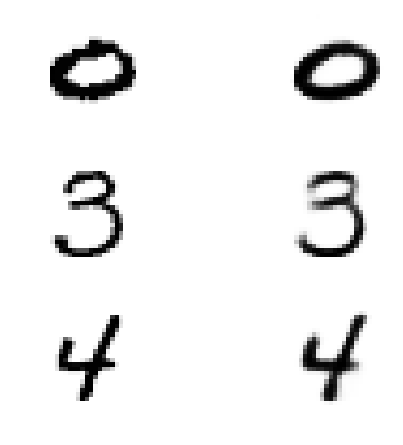

In [111]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

### Generate digits

Now let’s use this variational autoencoder to generate images that look like handwritten digits. All we need to do is train the model, then sample random codings from a Gaussian distribution and decode them.

In [112]:
n_rows = 6
n_cols = 10
n_digits = n_rows * n_cols
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_rnd})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


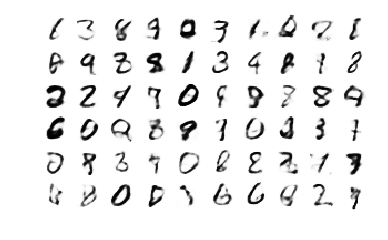

In [115]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)
plt.show()

### Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


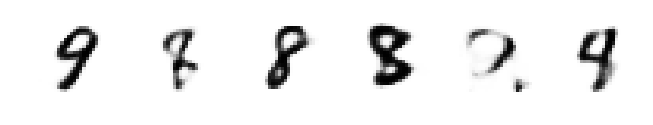

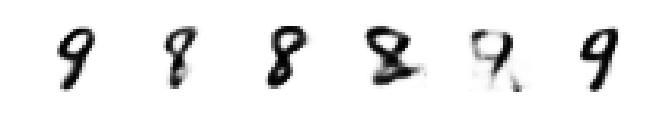

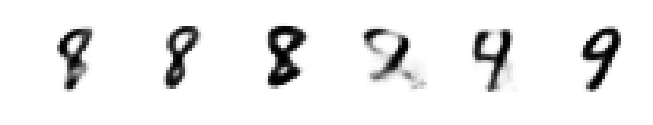

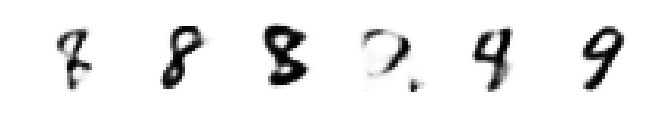

In [118]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()

## References 



* [William G. Chase, Herbert A. Simon, _Perception in chess_, Carnegie-Mellon University U.S.A., 1972](http://digitalcollections.library.cmu.edu/awweb/awarchive?type=file&item=44582)
* [Geoffrey E. Hinton, Simon Osindero, Yee-Whye Teh, _A Fast Learning Algorithm for Deep Belief Nets_, Neural Computation 18, 1527–1554 (2006)](http://www.cs.toronto.edu/~hinton/absps/ncfast.pdf)
* [Yoshua Bengio, Pascal Lamblin, Dan Popovici, Hugo Larochelle, _Greedy Layer-Wise Training of Deep Networks_, NIPS 2006](http://machinelearning.wustl.edu/mlpapers/paper_files/NIPS2006_739.pdf)
* [Pascal Vincent, Hugo Larochelle, Yoshua Bengio, Pierre-Antoine Manzagol, _Extracting and Composing Robust Features with Denoising Autoencoders_, 2008](https://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf)
* [Pascal Vincent, Hugo Larochelle, Isabelle Lajoie, Yoshua Bengio, Pierre-Antoine Manzagol,_Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion_, 2010](http://jmlr.csail.mit.edu/papers/volume11/vincent10a/vincent10a.pdf)
* Géron, Aurélien, _Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_. O'Reilly Media, 2017
* Salah Rifai, Pascal Vincent, Xavier Muller, Xavier Glorot, Yoshua Bengio, _Contractive Auto-Encoders: Explicit Invariance During Feature Extraction_, Proceedings of the 28 th International Conference on Machine Learning, Bellevue, WA, USA, 2011
* Jonathan Masci, Ueli Meier, Dan Cire¸san, and Jurgen Schmidhuber, _Stacked Convolutional Auto-Encoders for Hierarchical Feature Extraction_, ICANN 2011, Part I, LNCS 6791, pp. 52–59, 2011
* Guillaume Alain, Yoshua Bengio, Jason Yosinski, Eric Thibodeau-Laufer, Saizheng Zhang, Pascal Vincent, _GSNs: Generative Stochastic Networks_, 2015
* Alireza Makhzani, Brendan Frey, _Winner-Take-All Autoencoders_, 2015
* [Alireza Makhzani, Jonathon Shlens & Navdeep Jaitly, Ian Goodfellow, Brendan Frey, _Adversarial Autoencoders_, 2016](https://arxiv.org/pdf/1511.05644v2.pdf)
* [Diederik P. Kingma, Max Welling, _Auto-Encoding Variational Bayes_, 2014](https://arxiv.org/pdf/1312.6114v10.pdf)